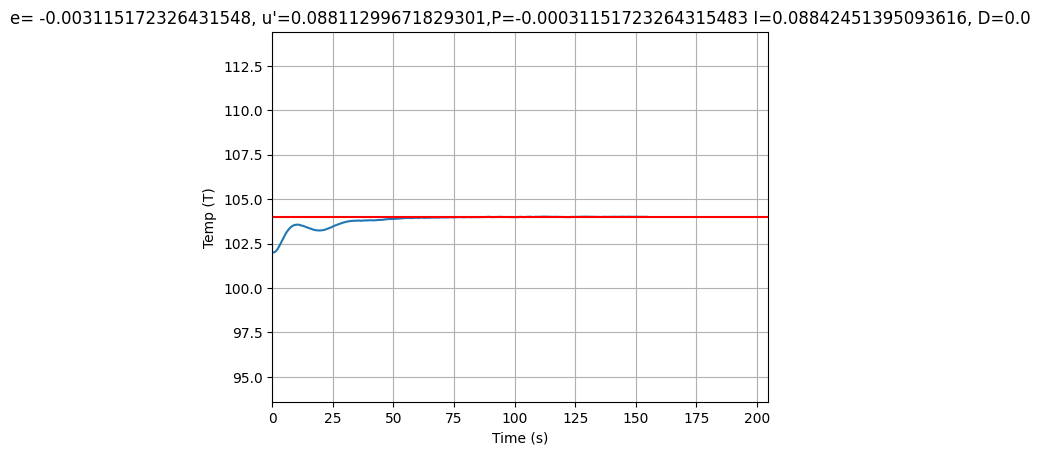

KeyboardInterrupt: 

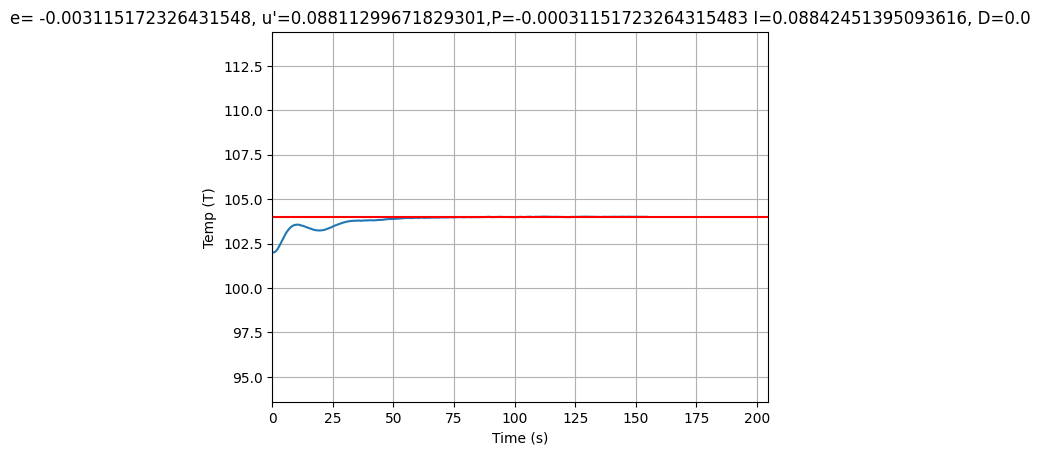

In [20]:
import numpy as np
import pyvisa 
import time
import csv
import matplotlib.pyplot as plt

from IPython.display import display, clear_output

rm = pyvisa.ResourceManager()

k2400_heater = rm.open_resource('GPIB0::2::INSTR')
k2400_sample_current = rm.open_resource('GPIB0::1::INSTR') #good
k2000_pt = rm.open_resource('GPIB0::26::INSTR') #good
k2000_sample_voltage = rm.open_resource('GPIB0::3::INSTR') #good


def get_current(device):
    return float(device.query(':MEASure:curr?').split(',')[1])

def get_voltage(device):
    return float(device.query(':MEASure:voltage?'))

def get_fres(device):
    return float(device.query(':MEASure:FRES?'))

def set_current(device, value):
    device.write(f':sour:current {value}')
    device.write(':outp on')

def set_current_range(device, value):
    device.write(f':sour:curr:range {value}')

def get_current_range(device):
    return device.query(':sour:curr:rang?')

def calc_temp(resistance):
    return ((resistance/100 - 1) * 255.86572669) + 273.15

t = []
T = []
E = []

int_t = []
int_E = []

total_t = 0

def temp_diff(T, T_target):
    diff = (T_target-T)
    return diff

window = 50

K_p = 0.50
K_i = K_p * 0.05
K_d = 0

max_current = 0.13

def I(error, time):
    if len(E) < 2:
        return 0
    
    return np.trapz(error, time)

def D(E, t):
    if len(E) < 2 or (t[-1] - t[-2])==0:
        return 0
    
    return (E[-1] - E[-2])/(t[-1] - t[-2]) 
    
         
def pid(heater, E, t, T, T_target):
    global int_t
    global int_E
    
    e = temp_diff(T, T_target)
    
    int_E.append(e)
    int_t.append(t[-1])
    
    if len(int_E) > window:
        int_E = int_E[1:window + 1]
        int_t = int_t[1:window + 1]
    
    
        
    u = min(K_p*temp_diff(T, T_target) + K_i * I(int_E, int_t) + K_d*D(E,t), max_current)
    plt.title(f"u'={u}, u={K_p*temp_diff(T, T_target) + (K_i * I(int_E, int_t)) + (K_d*D(E,t))},P={K_p*temp_diff(T, T_target)} int={K_i * I(int_E,int_t)}, D={K_d * D(E,t)}")

    
    
    u = max(u, 0)
    
    set_current(heater, u)

class PID():
    max_current = 0.2
    max_i_value = 1*100
    
    def __init__(self, K_p, K_i, K_d, update_period, set_point):
        self.set_point = set_point
        
        self.K_p = K_p
        self.K_i = K_i
        self.K_d = K_d
        
        self.update_period = update_period
        
        self.E = []
        self.t = []
        
        self.use_integration = False
        
    def P(self, error):
          return self.K_p * error

    def I(self, error):
        if abs(error / self.set_point) <= 0.1/16:
            self.use_integration = True
        
        if self.use_integration:            
            self.E.append(error)
            if len(self.t) == 0:
                self.t = [0.0]
            else:
                self.t.append(self.t[-1] + self.update_period)
            
            integral_value = np.trapz(self.E, self.t)
        else:
            integral_value = 0
            
        return self.K_i * integral_value
    
    def D(self):
        if not self.use_integration:
            return 0
        
        if len(self.E) >= 2:
            derrivative_value =  (self.E[-1] - self.E[-2]) / (self.t[-1] - self.t[-2])
        else:
            derrivative_value = 0
            
        return self.K_d * derrivative_value
        
    
    def get_control(self, temp):
        error = self.set_point - temp
        
        plt.title(f'')
        
        P = self.P(error)
        I = self.I(error)
        D = self.D()
        
        control =  P + I + D
        plt.title(f"e= {error}, u'={control},P={P} I={I}, D={D}")

        control = max(min(control, self.max_current), 0)
        return control

set_current(k2400_heater, 0)

K_p = 0.1 
K_i = K_p / 20
K_d = 0

period = 0.7
T_target = 104

pid = PID(K_p, K_i, K_d, period, T_target)

plt.figure()


line, = plt.plot([], [])
plt.xlabel('Time (s)')
plt.ylabel('Temp (T)')

plt.axhline(y=T_target, color='r')
plt.grid()

set_current_range(k2400_sample_current, 0.2)
set_current_range(k2400_heater, 0.2)

while True:
    resis = get_fres(k2000_pt)
    temp = calc_temp(resis)
    
    t.append(total_t)
    T.append(temp)
    E.append(temp_diff(temp, T_target))
    
    control = pid.get_control(temp)
    set_current(k2400_heater, control)

    zoom = 0.1
    
    line.set_xdata(t)
    line.set_ydata(T)
    plt.xlim(0, 1*np.max(t)+50)
    plt.ylim((T_target*(1 - zoom), T_target*(1 + zoom)))
    #plt.ylim((50, 400))
    
    plt.draw()
    
    clear_output(wait=True)
    display(plt.gcf())

    total_t += period
    time.sleep(period)